In [57]:
import matplotlib.pyplot as plt
import numpy as np

This notebook is based on [Recurrent Neural Networks (RNNs), Clearly Explained!!!](https://www.youtube.com/watch?v=AsNTP8Kwu80) by StatQuest.

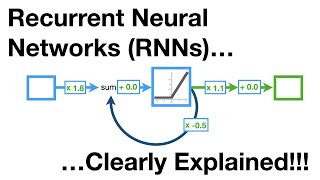

I implemented the concepts discused in the video, so you can experiment with them on your own.

## Setup

The following function is used to visualize the input data that is being used as well as the predicted outcome from the RNN.

In [58]:
def plot_data(X, Y, title, dotted=True):
  figsize = len(X[0]) + 1
  fig, axis = plt.subplots(1, len(X), figsize=(figsize * len(X), figsize))
  if not isinstance(axis, np.ndarray):
    axis = np.array([axis])

  # Set aspect ratio and y-axis limits for all subplots
  for ax in axis:
      ax.set_aspect('auto', adjustable='box')
      ax.set_ylim(0, 1)
      ax.set_xlim(0, figsize)

  space = np.linspace(0, figsize, figsize)

  # Input values
  for i, x in enumerate(X):
    axis[i].plot(space, x + [np.nan], label="x")

  # Values to be predicted by the RNN
  continuation_point = figsize / (figsize - 1) * (figsize - 2)
  for i, y in enumerate(Y):
    axis[i].plot([continuation_point, figsize], [X[i][-1],y], linestyle='dotted' if dotted else 'solid', label="y")

  plt.suptitle(title)
  plt.legend()
  plt.show()

### Data

We will consider the following graphs and use them to make predictions with the RNN. All of them are also included in the StatQuest video.

- Three simple graphs, representing rising, falling and constant lines
- A more complicated form, which falls and rises

In [59]:
data_rising = [0, 0.5] # expected continuation: 1
data_constant = [0.5, 0.5] # expected continuation: 0.5
data_falling = [1, 0.5] # expected continuation: 0
data_curve = [1, 0.5, 0.5] # expected continuation: 1

It's important to note that the values in these arrays have to be normalized, that is to have values between 0 and 1. Otherwise, the model won't make accurate predictions

## RNN

Here comes the RNN. It consists of two linear layers and an activation function between the two. The feedback loop takes the output from the first linear layer + activation function and uses it as the input for another forward pass, by summing it up with the bias. The input array `X` can be of any length, and all elements will be iterated from first to last. At the last element, the forward function returns an actual value, which is being influenced by all the previous forward passes.

This enables the model to take past datapoints into consideration.

In [60]:
def lin(x, w, b):
  return x*w+b

class MiniRnn():
  w1 = 1.8 # weight linear layer
  w2 = -0.5 # weight feedback loop
  w3 = 1.1 # weight output layer
  b = 0.0

  def forward(self, X):
    f = 0
    for x in X:
      l1 = lin(x, self.w1, self.b + f)
      relu = abs(l1)
      f = relu * self.w2
    l2 = lin(relu, self.w3, self.b)
    return round(l2, 1)

The above implementation is being implemented in an iterative way. This doesn't have any effect on the output, but to make our Recurrent Neural Network really **recursive**, it can be refactored like so:

In [61]:
class MiniRnn():
  w1 = 1.8 # weight linear layer
  w2 = -0.5 # weight feedback loop
  w3 = 1.1 # weight output layer
  b = 0.0

  def forward(self, X, i=0, f=0):
    # Linear layer + non-linearity
    l1 = lin(X[i], self.w1, self.b + f)
    relu = abs(l1)

    # Feedback loop
    if(i+1 != len(X)):
      f = relu * self.w2
      return self.forward(X, i+1, f)

    # Final output
    l2 = lin(relu, self.w3, self.b)
    return round(l2, 1)

The values for `w1`, `w2`, `w3` are adapted from the StatQuest video. However, in the second part of this notebook, we will find them on our own using gradient descent.

In [62]:
rnn = MiniRnn()

## Simple forms

These arrays of values represent the simplest forms one can imagine: a single line. We will see, if the RNN can correctly predict the next value!

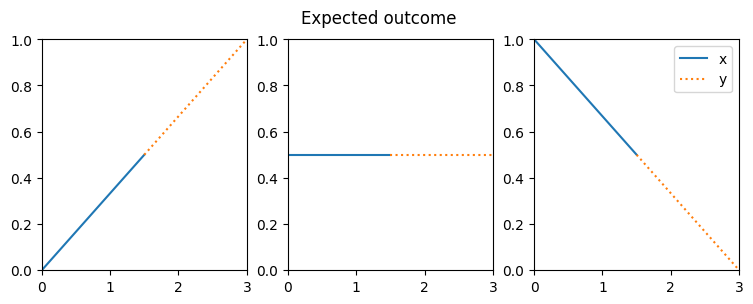

In [63]:
plot_data([data_rising, data_constant, data_falling],[1, 0.5, 0], "Expected outcome")

In [64]:
r1, r2, r3 = rnn.forward(data_rising), rnn.forward(data_constant), rnn.forward(data_falling)
r1, r2, r3

(1.0, 0.5, 0.0)

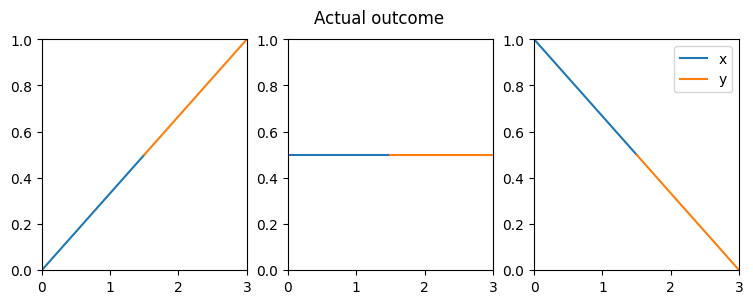

In [65]:
plot_data([data_rising, data_constant, data_falling],[r1,r2,r3], "Actual outcome", dotted=False)

As you can see, the RNN is able to predict the next value for simple lines.

## More complicated forms

The next form is a bit more complicated then the first few examples. It requires the RNN to remember that the starting point was pretty high initially, so that it makes the right decision on what the next value will be.

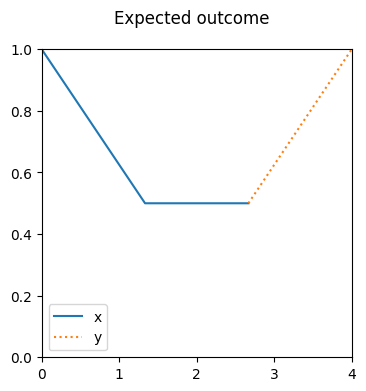

In [66]:
plot_data([data_curve],[1], "Expected outcome")

In [67]:
r4 = rnn.forward(data_curve)
r4

1.0

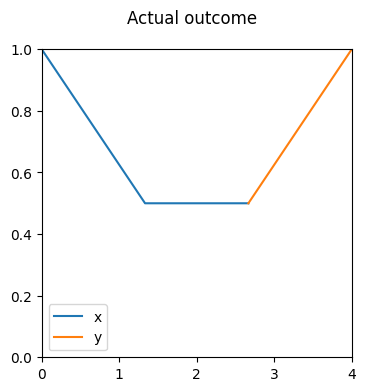

In [68]:
plot_data([data_curve],[1], "Actual outcome", dotted=False)

Again, the RNN correctly predicts the next value. Nice!

To understand each step in detail, here are the calculations in our RNN took in it's calculation process. Each variable represents one `forward` call. In this case, it's 3 because the array of input values had the length 3.

In [69]:
l1 = abs(1 * 1.8 + 0) * -0.5
l2 = abs(0.5 * 1.8 + l1) * -0.5
l3 = abs(0.5 * 1.8 + l2) * 1.1
round(l1,1),round(l2,1),round(l3,1)

(-0.9, -0.0, 1.0)

## Testing the limits

Up until this point, I only used the examples and exact values from the StatQuest video. However, these are not the only values we should try out. Here are some other values that the model should be able to predict:

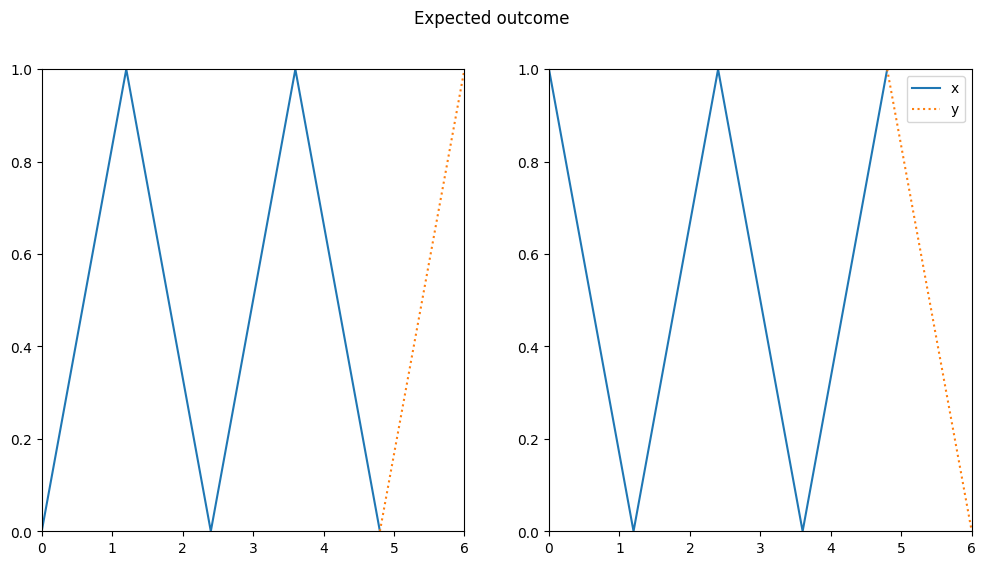

In [70]:
data_zic_zac = [0, 1, 0, 1, 0] # expected continuation: 1
data_zic_zac2 = [1, 0, 1, 0, 1] # expected continuation: 0
r5 = rnn.forward(data_zic_zac)
r6 = rnn.forward(data_zic_zac2)
plot_data([data_zic_zac, data_zic_zac2],[1, 0], "Expected outcome")

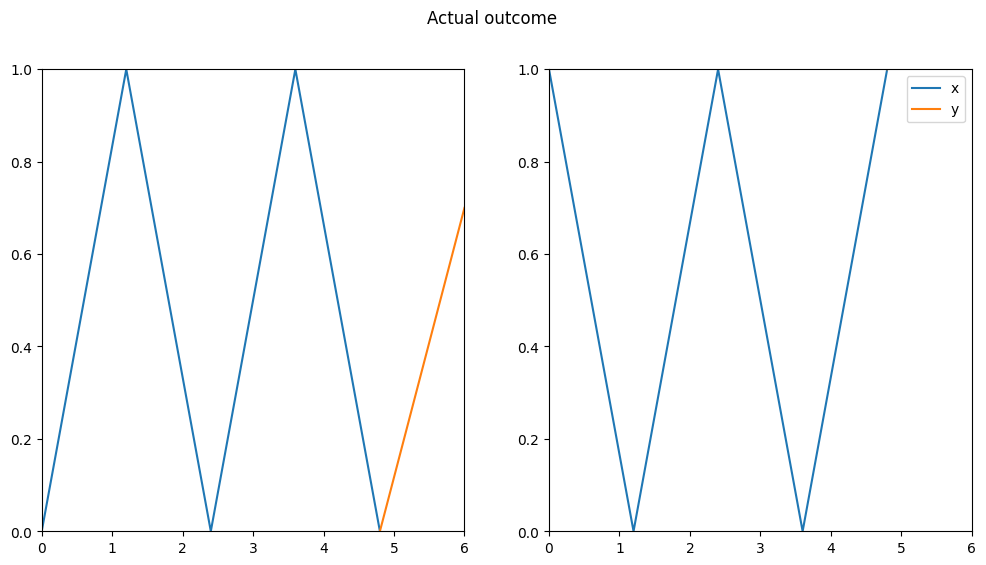

In [71]:
plot_data([data_zic_zac, data_zic_zac2],[r5, r6], "Actual outcome", dotted=False)

As you can see, the model doesn't generalize very well. The predictions are incorrect! Does that mean that RNNs are useless and that the StatQuest video was wrong? No, it just means that the weights for our model need to be adjusted so that it works on other kinds of data as well.

## Part 2

How do we adjust the weights? Of course, using gradient descent. In the next part of this notebook, I'll use gradient descent to update the weights of the RNN so that it's able to predict the next values for more datasets.